# Recommendation 5: Assessing Model Fits in Time-Resolved Spectral Parameterization


### Issue

Within the specparam tool, there are two goodness-of-fit metrics to assess how well your model is fitting your data: R-squared and mean squared error. Power spectra fit can be influenced by many factors, such as short time windows, sample size, and model hyperparameter specifications. 

### Solution

Here, we walk through some examples of how to investigate model fits based on these various factors.

### Related Work

The following papers include discussion of this topic:

- [LINK](LINK), AUTHORS, YEAR

### Related Discussion / Examples

The following examples discuss related topics:
-  [LINK](LINK), DESCRIPTION

In [17]:
# General imports
import numpy as np
import matplotlib.pyplot as plt

# Import the model objects
from specparam import SpectralModel, SpectralGroupModel

# Import some utilities for creating simulated power-spectra
from specparam.sim import sim_power_spectrum, sim_group_power_spectra
from specparam.sim.params import param_sampler
from specparam.sim.utils import set_random_seed

from neurodsp.sim import sim_combined, sim_knee, sim_peak_oscillation, sim_frac_gaussian_noise, sim_powerlaw
from neurodsp.spectral import compute_spectrum
from neurodsp.plts.time_series import plot_time_series
from neurodsp.utils import create_times, set_random_seed

In [2]:
# Add path and import custom code for the project
import sys
sys.path.append('code')

### Settings

In [3]:
import seaborn as sns
sns.set_context('poster')

In [4]:
# Set random seed
set_random_seed(808)

In [9]:
# Set whether to save out figures
SAVE_FIG = False

### Shorter Time Windows Lead to Poorer Model Fits

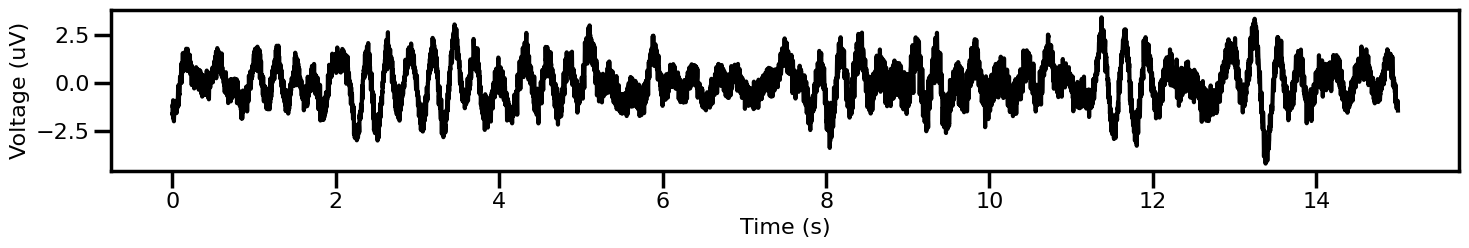

In [57]:
## Simulate timeseries as a combination of aperiodic and periodic components + noise
sim_components = {'sim_knee': {'exponent1' : 0, 'exponent2':-5, 'knee':10},
                   'sim_oscillation': [{'freq' : 4}, {'freq' : 50}]}
fs = 1000
n_seconds = 15
ap_sig = sim_knee(n_seconds, fs,**sim_components['sim_knee'])
sig = sim_peak_oscillation(ap_sig, fs, freq=sim_components['sim_oscillation'][0]['freq'], bw=1, height=3)
sig = sim_peak_oscillation(sig, fs, freq=sim_components['sim_oscillation'][1]['freq'], bw=0.5, height=8)

# Add noise
noise = sim_powerlaw(n_seconds, fs, exponent=0, f_range=(0.1, 200))
sig = sig + 0.3 * noise

times = create_times(n_seconds=n_seconds, fs=fs)
plot_time_series(times, sig)

In [60]:
win_len = int(1 * fs)
step = win_len//2  # 50% overlap

all_freqs = []
all_powers = []

for start in range(0, len(sig) - win_len + 1, step):
    seg = sig[start:start + win_len]

    freqs, powers = compute_spectrum(seg, fs=fs, f_range=(0.1, 200), avg_type='median', nperseg=fs, noverlap=fs // 2
    )

    all_freqs.append(freqs)
    all_powers.append(powers)

all_freqs = np.array(all_freqs)     # shape: (n_windows, n_freqs)
all_powers = np.array(all_powers)   # shape: (n_windows, n_freqs)

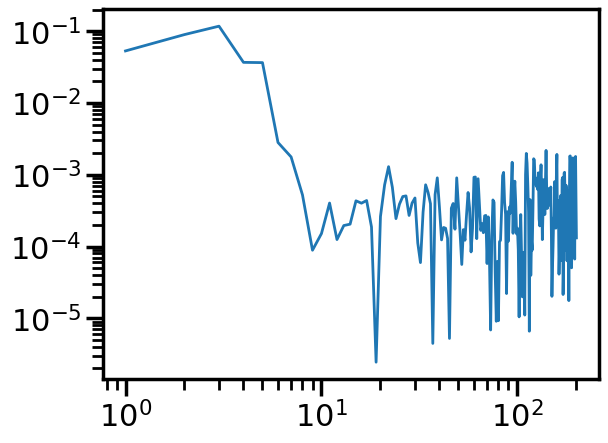

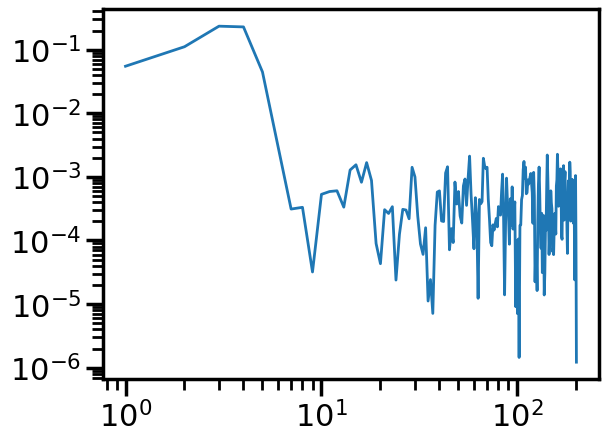

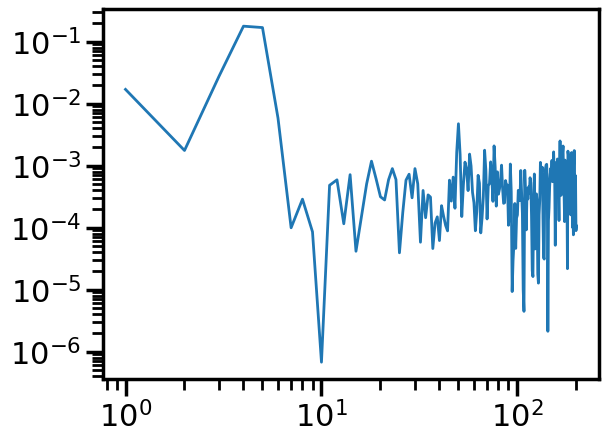

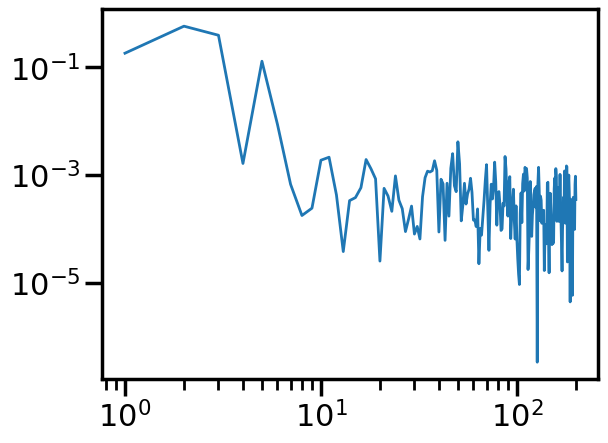

In [61]:
for window_i in np.arange(0, 4):
    plt.loglog(all_freqs[window_i], all_powers[window_i], linewidth=2)
    plt.show()

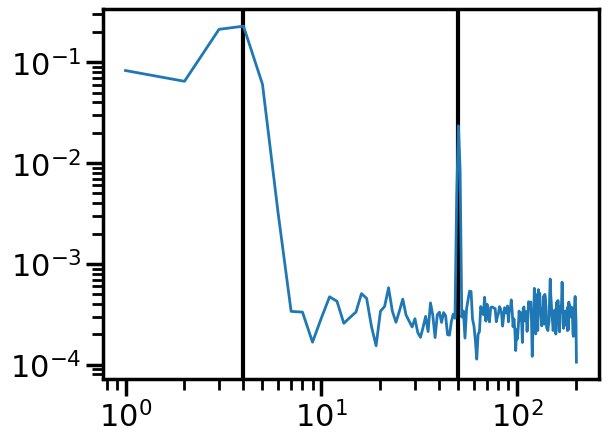

In [63]:
## Compute the power spectrum using Welch's 
freqs, powers = compute_spectrum(sig, fs=fs, f_range=(0.1,200), avg_type='median', nperseg=fs, noverlap=fs/2)

plt.axvline(sim_components['sim_oscillation'][0]['freq'], color='k')
plt.axvline(sim_components['sim_oscillation'][1]['freq'], color='k')
plt.loglog(freqs,powers, linewidth=2)


	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

                                                                                                  
                                       POWER SPECTRUM MODEL                                       
                                                                                                  
                       The model was run on the frequency range 1 - 100 Hz                        
                                 Frequency Resolution is 1.00 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -3.3444,

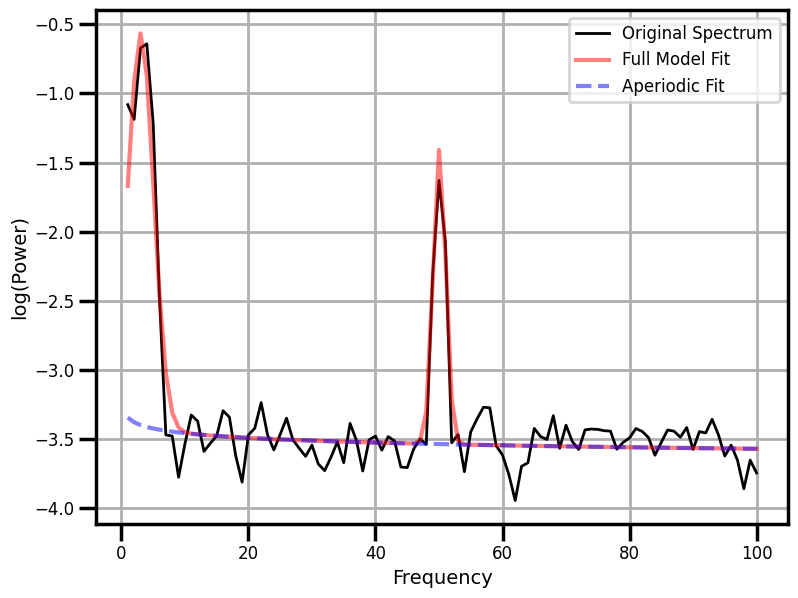

In [66]:
fm = SpectralModel(peak_width_limits=[1, 8], max_n_peaks=6, min_peak_height=0.4)
fm.report(freqs, powers, freq_range=(0,100))


	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

                                                                                                  
                                       POWER SPECTRUM MODEL                                       
                                                                                                  
                       The model was run on the frequency range 1 - 100 Hz                        
                                 Frequency Resolution is 1.00 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -1.3965,

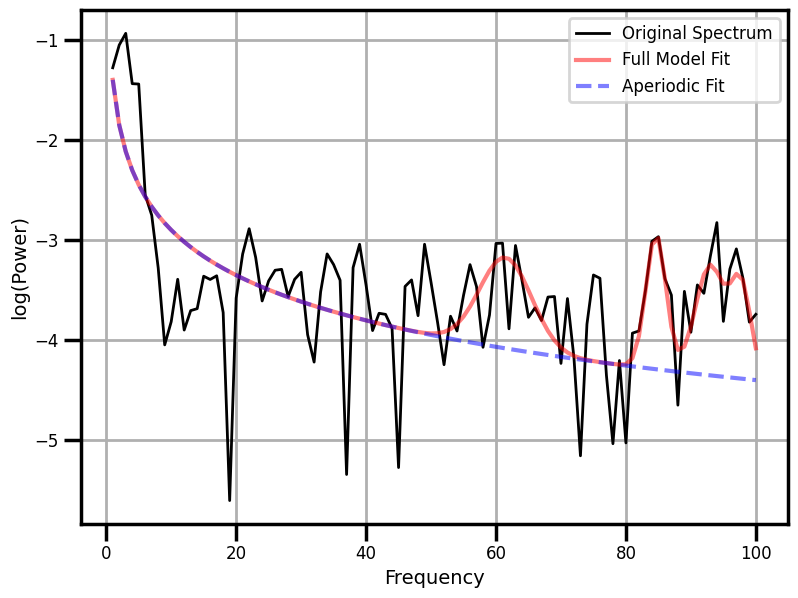

In [67]:
fm = SpectralModel(peak_width_limits=[1, 8], max_n_peaks=6, min_peak_height=0.4)
fm.report(all_freqs[0], all_powers[0], freq_range=(0,100))

### SECTION II TITLE

### Conclusion

<>